In [1]:


!pip3 install -qq google-play-scraper


In [2]:

!pip3 install -qq -U watermark

In [3]:
!pip3 install tqdm

In [4]:
!pip3 install -qq seaborn

In [5]:

%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

CPython 3.6.9
IPython 5.5.0

pandas 1.0.5
matplotlib 3.2.2
seaborn 0.10.1
google_play_scraper 0.1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Selected some apps for which we want to work basically from Productivity category. 

In [7]:

app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]



In [8]:
len(app_packages)

15

Scrapping App Infromation

In [9]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='in')
  del info['comments']
  app_infos.append(info)

100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


In [10]:

print(app_infos)

[{'title': 'Any.do: To do list, Calendar, Planner & Reminders', 'description': '<b>🏆 Editor\'s Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>🥇 "A MUST HAVE APP" (Lifehacker, NYTimes, USA TODAY, WSJ).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n📅 Organize Your Tasks & To-Do List in Seconds\r\n\r\n• ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day Calendar view, Weekly calendar view & agenda view, with built-in reminders. Review and organize your calendar events and to do list side by side.\r\n\r\n• SYNCS SEAMLESSLY - Keeps all your to do list, tasks, reminders, notes, calendar & agenda al

In [11]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [12]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": null,
  "contentRating": "Rated for 3+",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"A MUST HAVE APP\" (Lifehacker, NYTimes, USA TODAY, WSJ).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day Calendar view, Weekly calenda

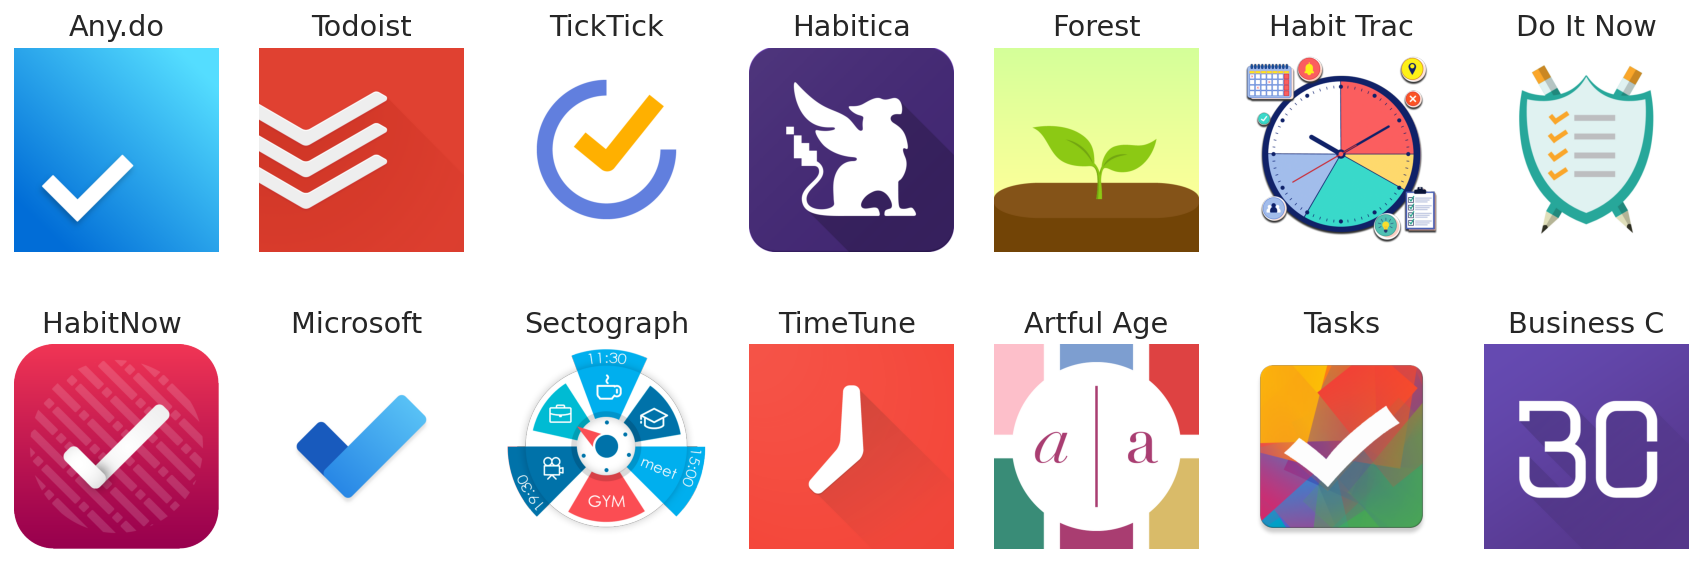

In [13]:

def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(15, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

In [14]:

app_infos_df = pd.DataFrame(app_infos)
app_infos_df.head()


,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,saleTime,originalPrice,saleText,offersIAP,inAppProductPrice,size,androidVersion,androidVersionText,developer,developerId,developerEmail,developerWebsite,developerAddress,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,appId,url
0,"Any.do: To do list, Calendar, Planner & Reminders",<b>🏆 Editor's Choice by Google</b>\r\n\r\nAny....,<b>🏆 Editor&#39;s Choice by Google</b><br><br>...,Task Manager ✅ Organizer 📅 Agenda 📝 Daily Remi...,Task Manager ✅ Organizer 📅 Agenda 📝 Daily Remi...,"10,000,000+",10000000,4.379973,352117,124990,"[30837, 10112, 16259, 32118, 262791]",0,True,USD,False,None,None,None,True,"₹51.00 - ₹5,520.00 per item",Varies with device,Varies,Varies with device,Any.do To-do list & Calendar,5304780265295461149,feedback+androidtodo@any.do,https://www.any.do,"Any.do Inc.\n\n6 Agripas Street, Tel Aviv\n62...",https://www.any.do/privacy,5304780265295461149,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/zgOLUXCHkF91...,https://lh3.googleusercontent.com/umhDP6phYKbu...,[https://lh3.googleusercontent.com/DKoi-PetUjx...,https://www.youtube.com/embed/2nkllLD0x6o?ps=p...,https://i.ytimg.com/vi/2nkllLD0x6o/hqdefault.jpg,Rated for 3+,None,None,None,"Nov 10, 2011",1597046991,Varies with device,- Redesigned Any.do Moment\r\n- New app naviga...,- Redesigned Any.do Moment<br>- New app naviga...,com.anydo,https://play.google.com/store/apps/details?id=...
1,"Todoist: To-Do List, Tasks & Reminders","🏆 <b>2019 Editor's Choice</b> by Google\r\n🥇 ""...",🏆 <b>2019 Editor&#39;s Choice</b> by Google<br...,"""The best to-do list"" — The Verge. Tasks ✅ Rem...",&quot;The best to-do list&quot; — The Verge. T...,"10,000,000+",10000000,4.560985,206464,63003,"[7597, 3349, 7607, 34986, 152925]",0,True,USD,False,None,None,None,True,"₹50.00 - ₹3,108.00 per item",Varies with device,Varies,Varies with device,Doist,6748661820728732000,support@todoist.com,http://todoist.com,"Doist\n201 Mission Street, Suite 1200\nSan Fra...",https://todoist.com/Help/viewPrivacyPolicy,6748661820728732000,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/GK0SwEBVqlFB...,https://lh3.googleusercontent.com/sAjzU1fUnmqJ...,[https://lh3.googleusercontent.com/cealfl906mH...,None,None,Rated for 3+,None,None,None,"Nov 18, 2012",1597249658,Varies with device,⭐️ Skip to the important updates about your sh...,⭐️ Skip to the important updates about your sh...,com.todoist,https://play.google.com/store/apps/details?id=...
2,"TickTick: ToDo List Planner, Reminder & Calendar",🏆<b>Editor's Choice</b> by Google\r\n🥇<b>Great...,🏆<b>Editor&#39;s Choice</b> by Google<br>🥇<b>G...,Task & time manager by Editor’s Choice🏆. Get t...,Task &amp; time manager by Editor’s Choice🏆. G...,"1,000,000+",1000000,4.622518,64527,23883,"[2129, 887, 2421, 8334, 50756]",0,True,USD,False,None,None,None,True,"₹50.00 - ₹1,390.00 per item",Varies with device,Varies,Varies with device,Appest Inc.,7269704759597705101,ticktick.com@gmail.com,https://ticktick.com,2035 Sunset Lake Road\nNewark\nDelaware\nUS,https://ticktick.com/about/privacy,7269704759597705101,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/YSlqf3WBgIuN...,https://lh3.googleusercontent.com/m-kwaaJEP_P6...,[https://lh3.googleusercontent.com/ltTfT_1TMf9...,None,None,Rated for 3+,None,None,None,"Jun 19, 2013",1597753652,Varies with device,5800\r\n✨ Introducing a major update: Task Nes...,5800<br>✨ Introducing a major update: Task Nes...,com.ticktick.task,https://play.google.com/store/apps/details?id=...
3,Habitica: Gamify Your Tasks,Treat your life like a game to stay motivated ...,Treat your life like a game to stay motivated ...,Treat your life like a game to stay motivated ...,Treat your life like a game to stay motivated ...,"1,0

In [15]:
app_infos_df.to_csv('apps.csv', index=None, header=True)

Scrapping App Reviews:

In [16]:

app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='in',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 15/15 [00:45<00:00,  3.05s/it]


In [17]:
print_json(app_reviews[0])

{
  "appId": "com.anydo",
  "at": "2020-08-19 07:00:05",
  "content": "Scam premium that bypasses GooglePlay, On the mobile app you can only buy 1 year of premium while on the website a monthly payment is possible. People buy the monthly more often and the developer listed it on its personal website only to bypass google fee, thus i need to link my card on their site too",
  "repliedAt": "2020-08-19 09:07:16",
  "replyContent": "We offer monthly/yearly plans on Google play as part of our Premium offering. If you are having issues with seeing the monthly plan, please reach us at Premium@any.do :)",
  "reviewCreatedVersion": "5.4.0.6",
  "reviewId": "gp:AOqpTOFXbJGy8gYsM8t_77DiyuuwVuoffTPw7nhpnqesxai6GcCjsUTkf3fKgFbtcKnvyD-i1u7JK_L1lKSrXQ",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 3,
  "userImage": "https://lh3.googleusercontent.com/a-/AOh14GhmIARkjHPQhz8JtEbypUjGBvB-u7NOm4fcEcoIww",
  "userName": "Luka S"
}



In [18]:



len(app_reviews)

16110

In [19]:

app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFXbJGy8gYsM8t_77DiyuuwVuoffTPw7nhpnqe...,Luka S,https://lh3.googleusercontent.com/a-/AOh14GhmI...,"Scam premium that bypasses GooglePlay, On the ...",1,3,5.4.0.6,2020-08-19 07:00:05,We offer monthly/yearly plans on Google play a...,2020-08-19 09:07:16,most_relevant,com.anydo
1,gp:AOqpTOHNHm4OfbjkxEXXa51JwZEHAaDlvfSgN0OU256...,Lex S,https://lh3.googleusercontent.com/-FgDpDeEJLAw...,"I love this app, but I do have one major gripe...",1,112,5.2.0.23,2020-08-05 16:22:04,"We ensured that Any.do would be fairly priced,...",2020-08-10 07:41:21,most_relevant,com.anydo
2,gp:AOqpTOH1ZorKk-tQkAaJ5rawp-UmTlMsdXju-Fy-s-v...,Lindsay Peterson,https://lh3.googleusercontent.com/-PZYPmjKIeF4...,Worked great for a few years and then the past...,1,25,5.4.0.6,2020-08-14 12:23:05,This sounds very odd! Please reach out at http...,2020-08-16 07:54:30,most_relevant,com.anydo
3,gp:AOqpTOEujjLj56XVqumAkipImEqIAU3qTIuQjENPaOK...,Sam van Dijk,https://lh3.googleusercontent.com/-pO3wTIb4myA...,"Trash. Yes, it has some nice nifty features bu...",1,26,5.2.0.23,2020-07-21 22:17:25,"Premium users can edit, create and delete tags...",2020-07-23 15:57:51,most_relevant,com.anydo
4,gp:AOqpTOG_s5DxUI0ZMn_J0qc_X9sBWy0M0e0NFyJRl-a...,Eric Cox,https://lh3.googleusercontent.com/a-/AOh14Gjj4...,This new layout is just awful. Just ridiculous...,1,0,5.4.0.6,2020-08-19 02:23:18,Sorry to hear that Eric. Would you mind sharin...,2020-08-19 06:36:17,most_relevant,com.anydo


In [20]:
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

In [21]:
# !pip3 install -q -U watermark

In [22]:

!pip3 install -qq transformers

     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 12.5MB/s 
     |████████████████████████████████| 3.0MB 17.4MB/s 
     |████████████████████████████████| 890kB 29.1MB/s 


In [23]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.6.0+cu101
transformers 3.0.2


In [24]:
df = pd.read_csv("reviews.csv")
df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFXbJGy8gYsM8t_77DiyuuwVuoffTPw7nhpnqe...,Luka S,https://lh3.googleusercontent.com/a-/AOh14GhmI...,"Scam premium that bypasses GooglePlay, On the ...",1,3,5.4.0.6,2020-08-19 07:00:05,We offer monthly/yearly plans on Google play a...,2020-08-19 09:07:16,most_relevant,com.anydo
1,gp:AOqpTOHNHm4OfbjkxEXXa51JwZEHAaDlvfSgN0OU256...,Lex S,https://lh3.googleusercontent.com/-FgDpDeEJLAw...,"I love this app, but I do have one major gripe...",1,112,5.2.0.23,2020-08-05 16:22:04,"We ensured that Any.do would be fairly priced,...",2020-08-10 07:41:21,most_relevant,com.anydo
2,gp:AOqpTOH1ZorKk-tQkAaJ5rawp-UmTlMsdXju-Fy-s-v...,Lindsay Peterson,https://lh3.googleusercontent.com/-PZYPmjKIeF4...,Worked great for a few years and then the past...,1,25,5.4.0.6,2020-08-14 12:23:05,This sounds very odd! Please reach out at http...,2020-08-16 07:54:30,most_relevant,com.anydo
3,gp:AOqpTOEujjLj56XVqumAkipImEqIAU3qTIuQjENPaOK...,Sam van Dijk,https://lh3.googleusercontent.com/-pO3wTIb4myA...,"Trash. Yes, it has some nice nifty features bu...",1,26,5.2.0.23,2020-07-21 22:17:25,"Premium users can edit, create and delete tags...",2020-07-23 15:57:51,most_relevant,com.anydo
4,gp:AOqpTOG_s5DxUI0ZMn_J0qc_X9sBWy0M0e0NFyJRl-a...,Eric Cox,https://lh3.googleusercontent.com/a-/AOh14Gjj4...,This new layout is just awful. Just ridiculous...,1,0,5.4.0.6,2020-08-19 02:23:18,Sorry to hear that Eric. Would you mind sharin...,2020-08-19 06:36:17,most_relevant,com.anydo


In [25]:
df.shape

(16110, 12)

In [26]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16110 entries, 0 to 16109
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16110 non-null  object
 1   userName              16110 non-null  object
 2   userImage             16110 non-null  object
 3   content               16110 non-null  object
 4   score                 16110 non-null  int64 
 5   thumbsUpCount         16110 non-null  int64 
 6   reviewCreatedVersion  13704 non-null  object
 7   at                    16110 non-null  object
 8   replyContent          7943 non-null   object
 9   repliedAt             7943 non-null   object
 10  sortOrder             16110 non-null  object
 11  appId                 16110 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB




Some Exploratory Data analysis: 

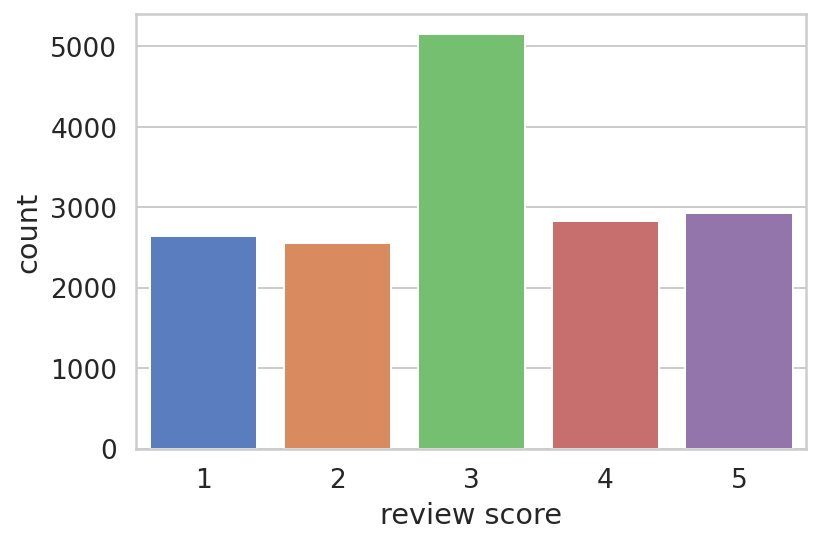

In [27]:

sns.countplot(df.score)
plt.xlabel('review score');


In [28]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [29]:
class_names = ['negative', 'neutral', 'positive']

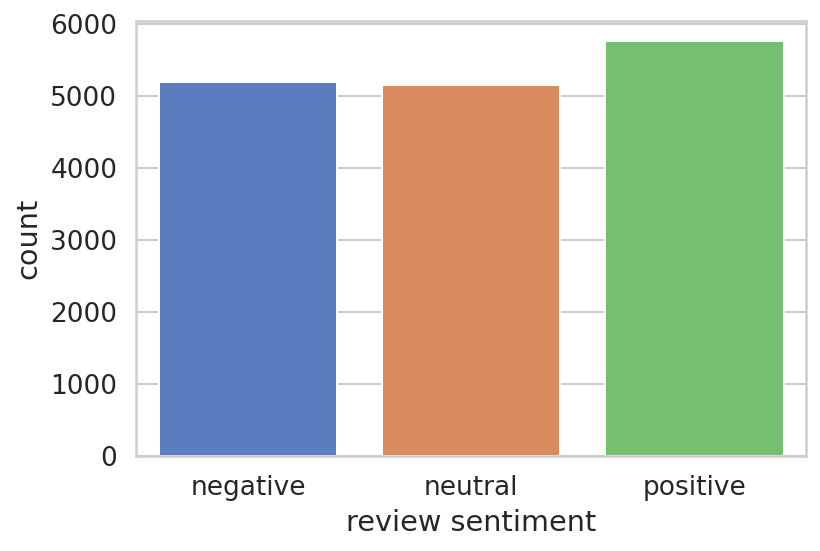

In [30]:

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [31]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [32]:
import logging
logging.basicConfig(level=logging.ERROR)

In [33]:
logging.getLogger("pytorch_pretrained_bert.tokenization").setLevel(logging.ERROR)

In [34]:
!nvidia-smi

Thu Aug 20 08:38:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Preprocessing

In [35]:
# !pip install -q -U watermark
# !pip install -qq transformers

In [36]:

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.6.0+cu101
transformers 3.0.2


In [37]:

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [38]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [39]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

INFO:filelock:Lock 140364700914128 acquired on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpftdsi7v0


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt in cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:filelock:Lock 140364700914128 released on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f2

In [40]:

sample_txt = 'When was I last outside? I am stuck at home for 5 months.'

In [41]:
tokens = tokenizer.tokenize(sample_txt) 
print(tokens)

['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '5', 'months', '.']


In [42]:



tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(tokens))
print(len(token_ids))
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

15
15
 Sentence: When was I last outside? I am stuck at home for 5 months.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '5', 'months', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 126, 1808, 119]


### Special Tokens

In [43]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [44]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [45]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [46]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [47]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [48]:


print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  126, 1808,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [49]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [50]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '5',
 'months',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

In [51]:

token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

In [52]:
len(token_lens)

16110

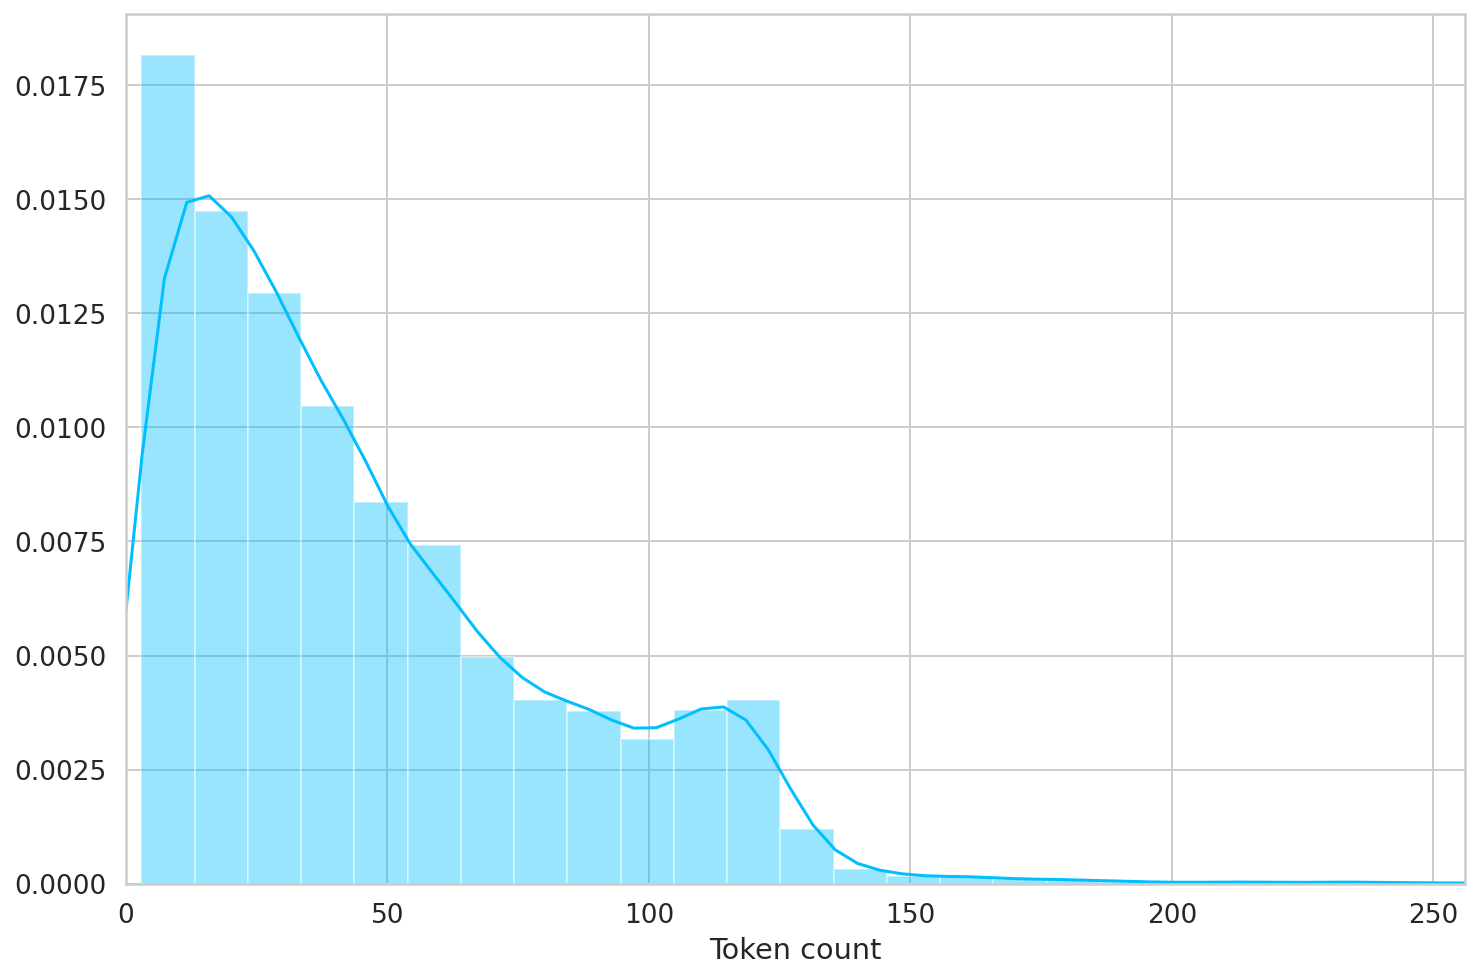

In [53]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

### Create Dataset

In [54]:

MAX_LEN = 160

In [55]:

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


In [56]:

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [57]:

df_train.shape, df_val.shape, df_test.shape

((14499, 13), (805, 13), (806, 13))

In [58]:
 torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [59]:
torch.cuda.empty_cache()

### Pytorch Data Loader Creation

In [60]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [61]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [62]:
data = next(iter(train_data_loader))
data.keys()



dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [63]:

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


### Sentiment Classification with BERT and Hugging Face

In [64]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

INFO:filelock:Lock 140364710814440 acquired on /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpcrcsbvwe


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json in cache at /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
INFO:filelock:Lock 140364710814440 released on /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df1

INFO:filelock:Lock 140364658605976 acquired on /root/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmppm6mbphr


INFO:transformers.file_utils:storing https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin in cache at /root/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
INFO:filelock:Lock 140364658605976 released on /root/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin from cache at /root/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2


INFO:transformers.modeling_utils:All model checkpoint weights were used when initializing BertModel.

INFO:transformers.modeling_utils:All the weights of BertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use BertModel for predictions without further training.


In [65]:

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [66]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [67]:
bert_model.config.hidden_size

768

In [68]:
pooled_output.shape

torch.Size([1, 768])

In [69]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [70]:

model = SentimentClassifier(len(class_names))
model = model.to(device)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin from cache at /root/.cache/torch/

In [71]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [72]:
import torch
torch.cuda.empty_cache()

In [73]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4273, 0.1643, 0.4084],
        [0.5035, 0.1228, 0.3737],
        [0.2618, 0.1440, 0.5942],
        [0.5822, 0.1033, 0.3145],
        [0.5882, 0.1665, 0.2453],
        [0.3324, 0.1653, 0.5023],
        [0.4129, 0.1482, 0.4389],
        [0.3128, 0.2470, 0.4402],
        [0.3324, 0.1675, 0.5001],
        [0.2633, 0.2209, 0.5158],
        [0.4219, 0.1761, 0.4019],
        [0.4029, 0.2056, 0.3915],
        [0.5517, 0.0800, 0.3683],
        [0.4814, 0.1439, 0.3747],
        [0.3952, 0.1690, 0.4357],
        [0.3635, 0.2141, 0.4225]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training:

In [74]:

EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [75]:

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [76]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [77]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7416336829337685 accuracy 0.6692875370715222
Val   loss 0.5892905014402726 accuracy 0.7639751552795031

Epoch 2/10
----------
Train loss 0.44767331133998084 accuracy 0.8311607697082558
Val   loss 0.5404861738868788 accuracy 0.7987577639751553

Epoch 3/10
----------
Train loss 0.2662810037233954 accuracy 0.9129595144492725
Val   loss 0.6286220500501347 accuracy 0.8322981366459627

Epoch 4/10
----------
Train loss 0.17982171557140572 accuracy 0.947099799986206
Val   loss 0.6869375652053813 accuracy 0.8409937888198759

Epoch 5/10
----------
Train loss 0.13387692433896412 accuracy 0.9611007655700394
Val   loss 0.7713425091670953 accuracy 0.8645962732919255

Epoch 6/10
----------
Train loss 0.08992920818778044 accuracy 0.9731705634871372
Val   loss 0.7932687888844121 accuracy 0.8683229813664597

Epoch 7/10
----------
Train loss 0.07691971009219571 accuracy 0.9777226015587283
Val   loss 0.897746313323938 accuracy 0.8695652173913044

Epoch 8/10
----------
Tr

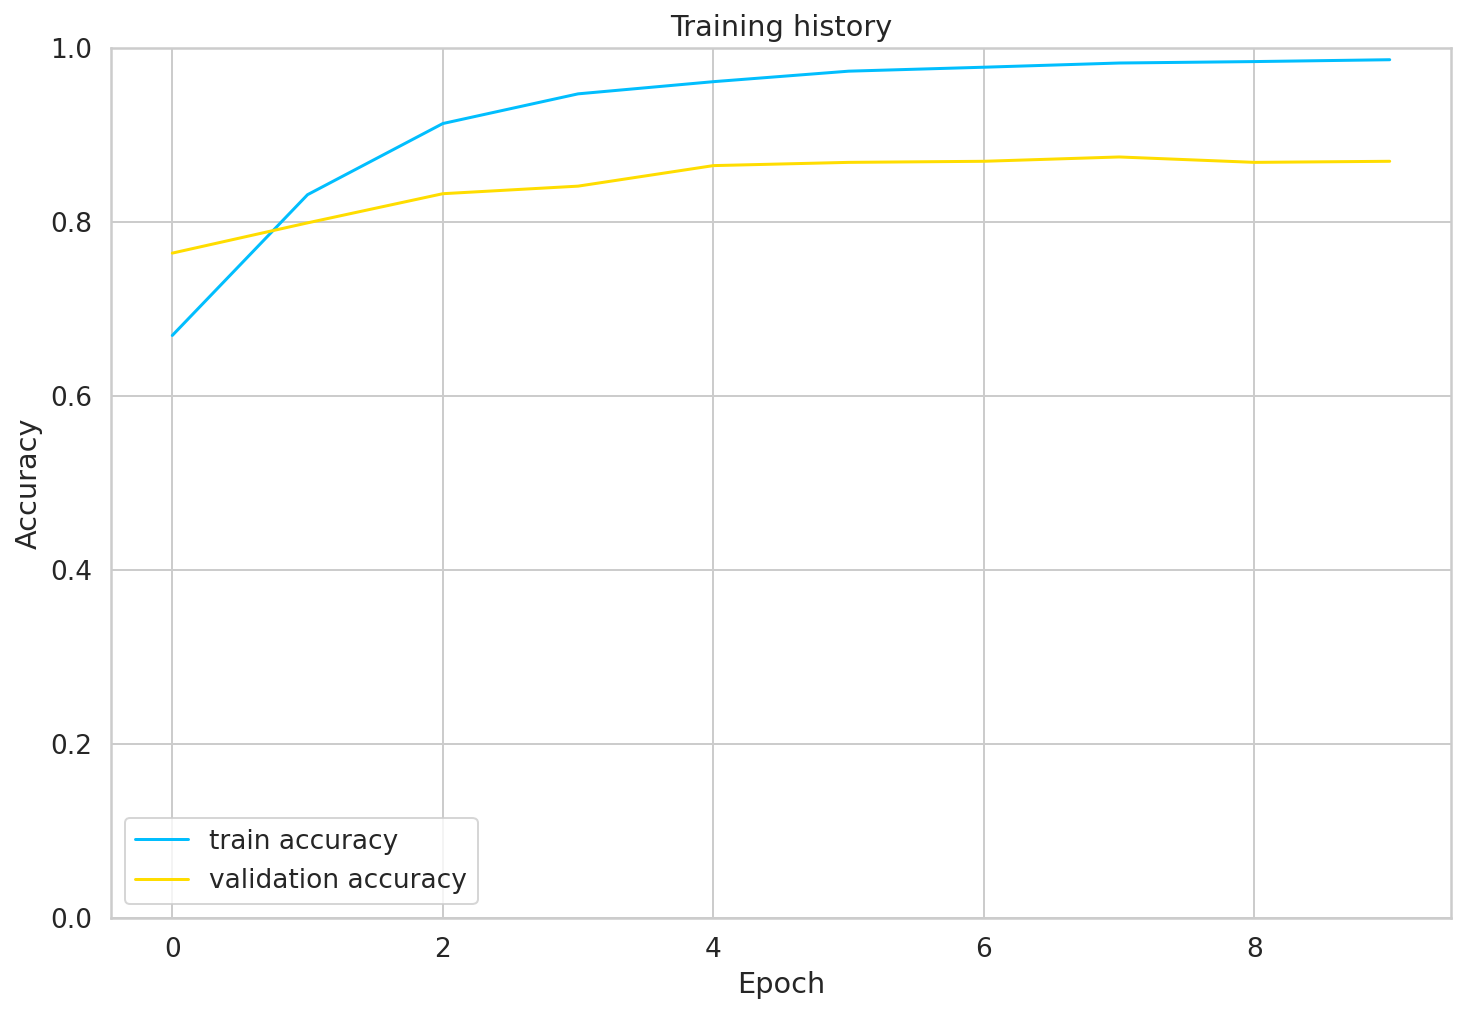

In [78]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [93]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


In [94]:
a_float = test_acc.item() * 100
formatted_float = "{:.2f}".format(a_float)
print(f'Accuracy = {formatted_float}%')

Accuracy = 87.59%


In [80]:

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [81]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [82]:

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.94      0.85      0.90       273
     neutral       0.78      0.85      0.81       235
    positive       0.90      0.92      0.91       298

    accuracy                           0.88       806
   macro avg       0.87      0.87      0.87       806
weighted avg       0.88      0.88      0.88       806



INFO:numexpr.utils:NumExpr defaulting to 2 threads.


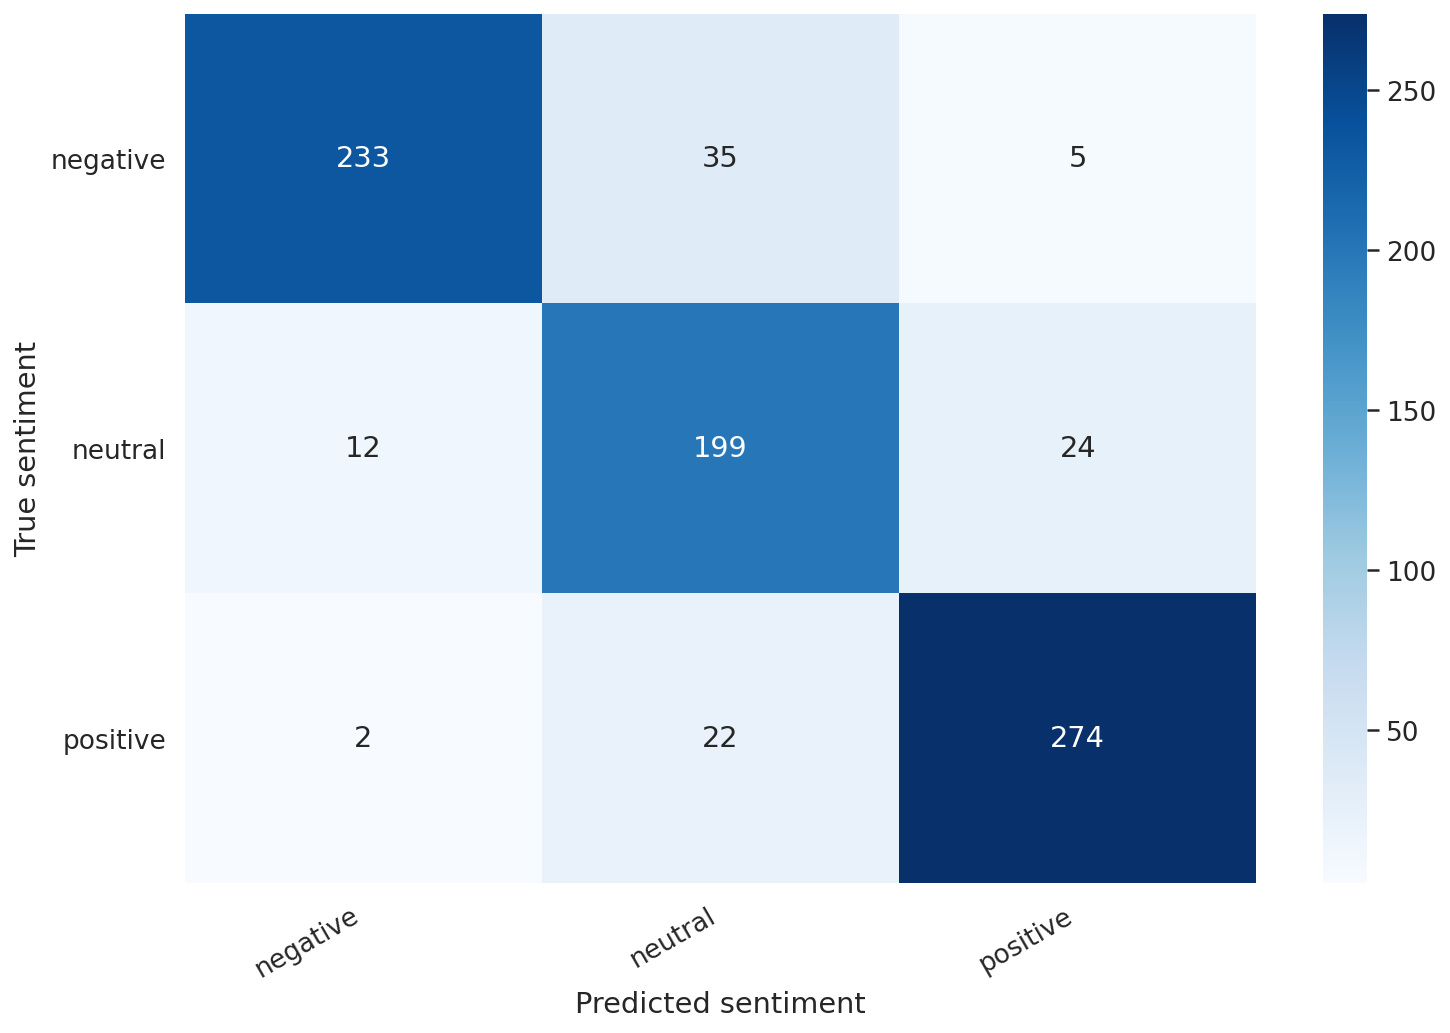

In [83]:

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [84]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [85]:

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Really great. You get coins when you grow trees (the more time you
study for the more coins you get) and with the coins, you can buy
different white noises for when you focus, and different types of
trees. I use it to study at home and it feels really rewarding and
disciplined. Also it's really cool watching your tree grow as you
work! :)

True sentiment: positive


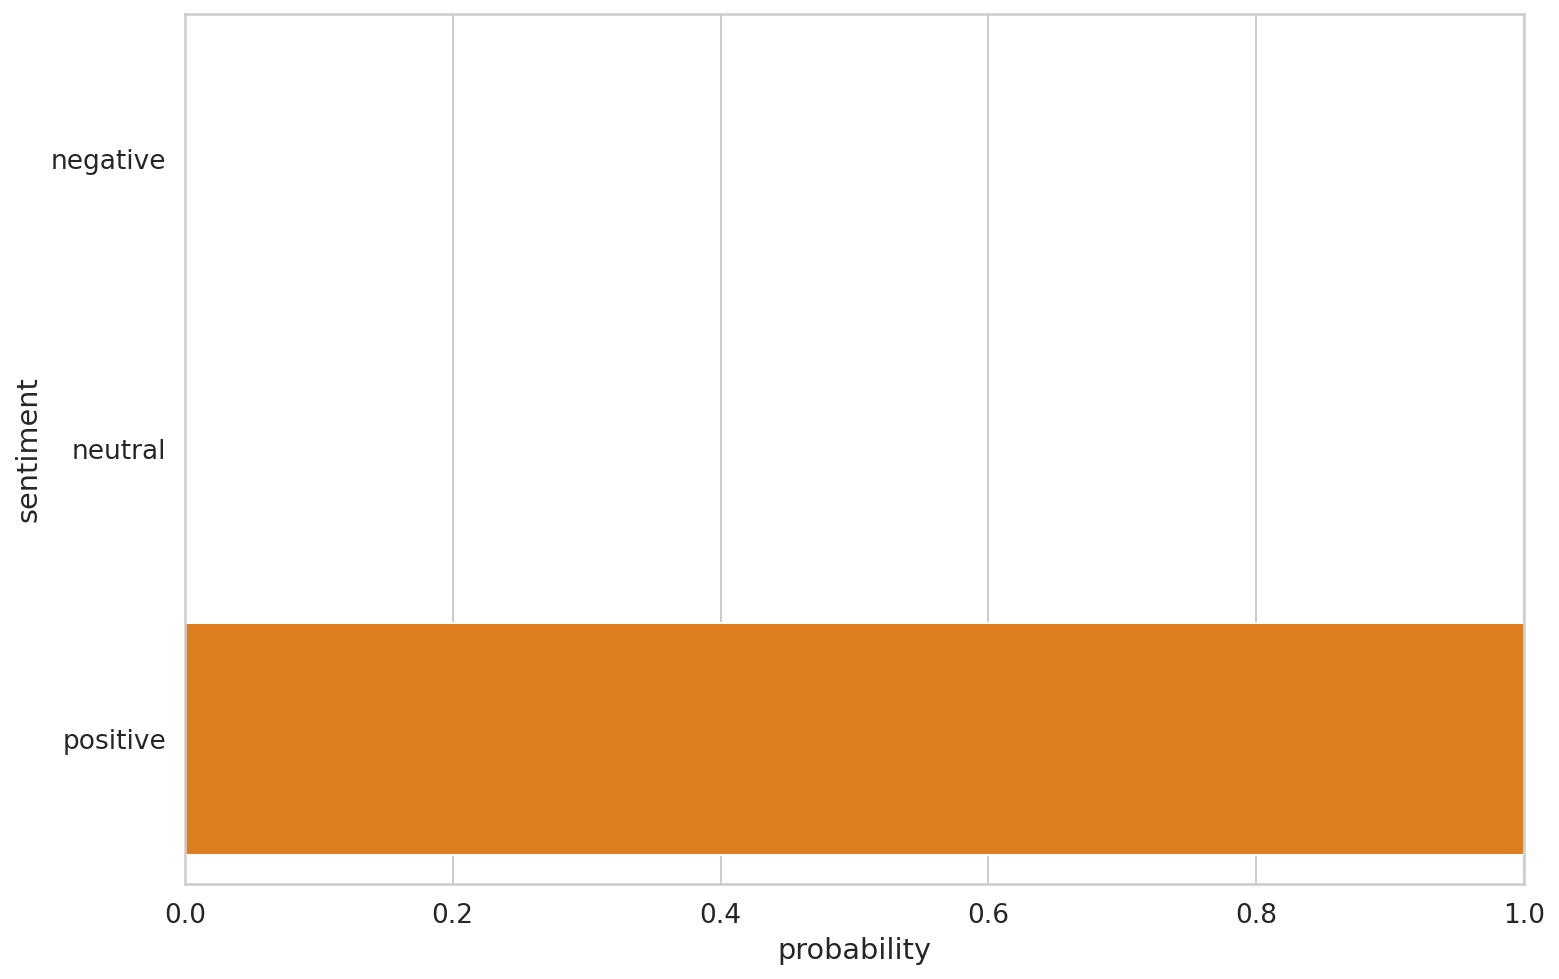

In [86]:

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [87]:
review_text = "I love completing my todos! Best app ever!!!"

In [88]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [89]:

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
